In [1]:
# importing libraries
import os
import cv2
import numpy as np
import pandas as pd
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import resample
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve

In [2]:
# Define dataset path and directories
DATASET = "dataset/brain_tumor_dataset"
base_dir = "dataset/preprocessed_brain_tumor_dataset"
CATEGORIES = ["no", "yes"]  # 'no' = No Tumor, 'yes' = Tumor
class_dirs = ['No Tumor', 'Tumor']

# Initialize a list to store counts of each class
class_counts = []

C:\Users\yacin\AppData\Local\Temp\ipykernel_31460\881667547.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Class', y='Count', data=class_distribution, palette='Blues')


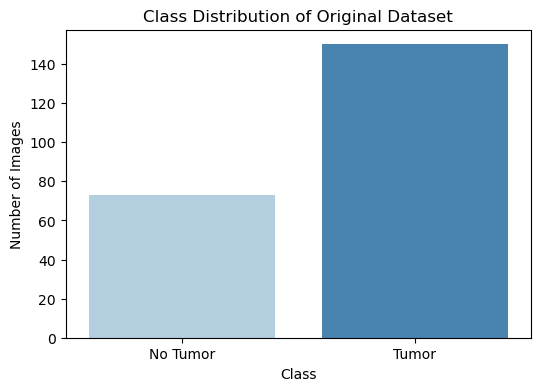

In [3]:
# Loop over the class directories and count the number of files (images)
for CATEGORIE in CATEGORIES:
    class_path = os.path.join(DATASET, CATEGORIE)
    # Count the number of files (images) in the directory
    num_files = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])
    class_counts.append(num_files)

# Create a DataFrame for easy plotting (if needed)
import pandas as pd
class_distribution = pd.DataFrame({
    'Class': class_dirs,
    'Count': class_counts
})

# Plotting the bar graph
plt.figure(figsize=(6, 4))
sns.barplot(x='Class', y='Count', data=class_distribution, palette='Blues')
plt.title('Class Distribution of Original Dataset')
plt.ylabel('Number of Images')
plt.xlabel('Class')
plt.show()

In [4]:
def resize_image(img_path, target_size=(224, 224)):
    try:
        img = Image.open(img_path)
        img = img.resize(target_size)
        img_array = np.array(img) / 255.0  # Normalize to [0, 1]
        
        # Convert grayscale to 3-channel RGB
        if len(img_array.shape) == 2:
            img_array = np.stack((img_array,) * 3, axis=-1)
        elif img_array.shape[2] == 4:  # RGBA image
            img_array = img_array[:, :, :3]  # Remove alpha channel
        
        return img_array
    except Exception as e:
        print(f"Error loading or processing image {img_path}: {e}")
        return None  # Return None for problematic images

In [5]:
def load_images(dataset, categories):
    data = []
    labels = []

    for category in categories:
        path = os.path.join(dataset, category)

        # Ensure the directory exists
        if not os.path.exists(path):
            print(f"Error: The directory {path} does not exist.")
            continue
        
        class_label = categories.index(category)

        for img_name in os.listdir(path):
            img_path = os.path.join(path, img_name)

            # Ensure the file exists and is an image
            if os.path.isfile(img_path):
                img = resize_image(img_path, target_size=(224, 224))
                if img is not None:  # Only add valid images
                    data.append(img)
                    labels.append(class_label)
                else:
                    print(f"Skipping image {img_name} due to an error")
            else:
                print(f"Skipping {img_name} as it's not a valid file.")
        
    return np.array(data), np.array(labels)


In [6]:
#having a visual of the data befor and after resizing to outcome resolution challange in the dataset
def visualize_samples(dataset, categories):
    fig, axes = plt.subplots(len(categories), 2, figsize=(8, len(categories) * 4))

    for i, category in enumerate(categories):
        path = os.path.join(dataset, category)
        
        if not os.path.exists(path):
            print(f"Error: Directory {path} does not exist.")
            continue

        img_files = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]
        if not img_files:
            print(f"No valid images found in {path}")
            continue
        
        img_path = os.path.join(path, img_files[0])  # Take the first image
        original_img = cv2.imread(img_path)
        resized_img = resize_image(img_path)

        if original_img is None or resized_img is None:
            print(f"Skipping {img_path} due to an error")
            continue

        original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

        # Display Original
        axes[i, 0].imshow(original_img)
        axes[i, 0].set_title(f"Original - {category}")
        axes[i, 0].axis("off")

        # Display Resized
        axes[i, 1].imshow(resized_img)
        axes[i, 1].set_title(f"Resized - {category}")
        axes[i, 1].axis("off")

    plt.tight_layout()
    plt.show()


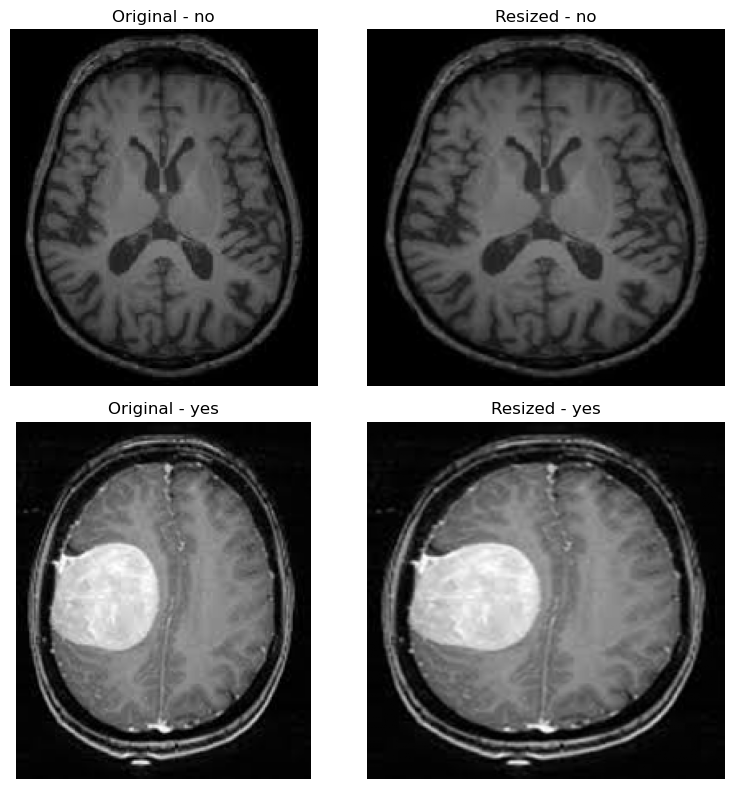

In [7]:
visualize_samples(DATASET, CATEGORIES)

In [8]:
# data augmentation to balance more the dataset 
def augment_images(X_data, y_data, target_class=0, augment_count=150):
    # Separate the target class (No Tumor) and the other class (Tumor)
    X_target = X_data[y_data == target_class]
    y_target = y_data[y_data == target_class]

    # Set up the ImageDataGenerator for augmentation 
    datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    
    augmented_images = []
    for i in range(len(X_target)):
        img = X_target[i].reshape((1, *X_target[i].shape))  # Reshape image to (1, height, width, channels)
        it = datagen.flow(img, batch_size=1, save_to_dir=None)
        
        # Generate augmented images 
        for _ in range(augment_count // len(X_target)):
            augmented_images.append(next(it)[0]) 
            
            if len(augmented_images) >= augment_count:
                break
        if len(augmented_images) >= augment_count:
            break
            
    return np.array(augmented_images)


In [9]:
# Save the images to the Dataset
def save_images_to_directory(X_data, y_data, target_dir):
    for i in range(len(X_data)):
        label = 'yes' if y_data[i] == 1 else 'no'
        img = Image.fromarray((X_data[i] * 255).astype(np.uint8))  # Convert from [0, 1] to [0, 255] for saving
        img_path = os.path.join(target_dir, label, f"img_{i}.jpg")
        img.save(img_path)

In [10]:
# Cout the number of pictures in each directory 
def count_classes(y_data):
    yes_count = np.sum(y_data == 1)
    no_count = np.sum(y_data == 0)
    return yes_count, no_count

In [11]:
# Create subdirectories for train, val, and test splits
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Create class subdirectories inside train, val, and test directories
train_tumor_dir = os.path.join(train_dir, 'yes')
train_no_tumor_dir = os.path.join(train_dir, 'no')

val_tumor_dir = os.path.join(val_dir, 'yes')
val_no_tumor_dir = os.path.join(val_dir, 'no')

test_tumor_dir = os.path.join(test_dir, 'yes')
test_no_tumor_dir = os.path.join(test_dir, 'no')

# Make sure the directories exist
os.makedirs(train_tumor_dir, exist_ok=True)
os.makedirs(train_no_tumor_dir, exist_ok=True)
os.makedirs(val_tumor_dir, exist_ok=True)
os.makedirs(val_no_tumor_dir, exist_ok=True)
os.makedirs(test_tumor_dir, exist_ok=True)
os.makedirs(test_no_tumor_dir, exist_ok=True)


In [12]:
# Load images from the original dataset
X, y = load_images(DATASET, CATEGORIES)

# Count the original distribution
yes_count = np.sum(y == 1)
no_count = np.sum(y == 0)
print(f"Original dataset - Yes (Tumor): {yes_count}, No (No Tumor): {no_count}")

# Balance the dataset
augmentation_count = yes_count - no_count  # To match the "Yes" class
X_no_augmented = augment_images(X, y, target_class=0, augment_count=augmentation_count)

# Combine the augmented images with the original dataset
X_balanced = np.concatenate([X, X_no_augmented], axis=0)
y_balanced = np.concatenate([y, np.zeros(len(X_no_augmented))], axis=0)  #

# Verify the new class distribution
yes_count_balanced = np.sum(y_balanced == 1)
no_count_balanced = np.sum(y_balanced == 0)
print(f"Balanced dataset - Yes (Tumor): {yes_count_balanced}, No (No Tumor): {no_count_balanced}")


Original dataset - Yes (Tumor): 150, No (No Tumor): 73
Balanced dataset - Yes (Tumor): 150, No (No Tumor): 146


C:\Users\yacin\AppData\Local\Temp\ipykernel_31460\2098369626.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Class', y='Count', data=class_distribution_balanced_df, palette='Blues')


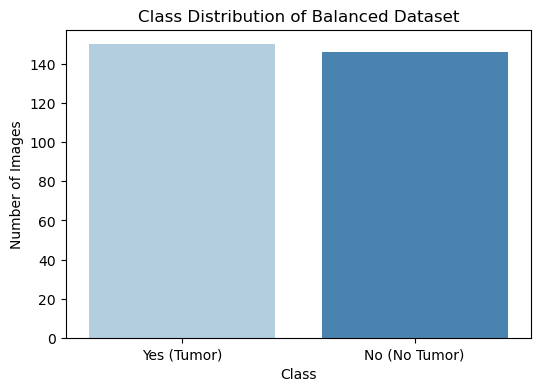

In [13]:
# Create the data for plotting
class_distribution_balanced = {
    'Class': ['Yes (Tumor)', 'No (No Tumor)'],
    'Count': [yes_count_balanced, no_count_balanced]
}

# Create a DataFrame for easy plotting
class_distribution_balanced_df = pd.DataFrame(class_distribution_balanced)

# Plotting the bar graph for the balanced dataset
plt.figure(figsize=(6, 4))
sns.barplot(x='Class', y='Count', data=class_distribution_balanced_df, palette='Blues')
plt.title('Class Distribution of Balanced Dataset')
plt.ylabel('Number of Images')
plt.xlabel('Class')
plt.show()

In [14]:
# Split the balanced dataset into training, validation, and test sets (80%/10%/10%) using stratified split

X_train, X_temp, y_train, y_temp = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Save images to corresponding directories (for the balanced dataset)
save_images_to_directory(X_train, y_train, train_dir)
save_images_to_directory(X_val, y_val, val_dir)
save_images_to_directory(X_test, y_test, test_dir)

# Print dataset shapes
print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")

# Print balanced counts
train_yes, train_no = count_classes(y_train)
val_yes, val_no = count_classes(y_val)
test_yes, test_no = count_classes(y_test)

print(f"Training set: (yes have {train_yes} pics, no have {train_no} pics)")
print(f"Validation set: (yes have {val_yes} pics, no have {val_no} pics)")
print(f"Test set: (yes have {test_yes} pics, no have {test_no} pics)")


Training set: (236, 224, 224, 3)
Validation set: (30, 224, 224, 3)
Test set: (30, 224, 224, 3)
Training set: (yes have 120 pics, no have 116 pics)
Validation set: (yes have 15 pics, no have 15 pics)
Test set: (yes have 15 pics, no have 15 pics)


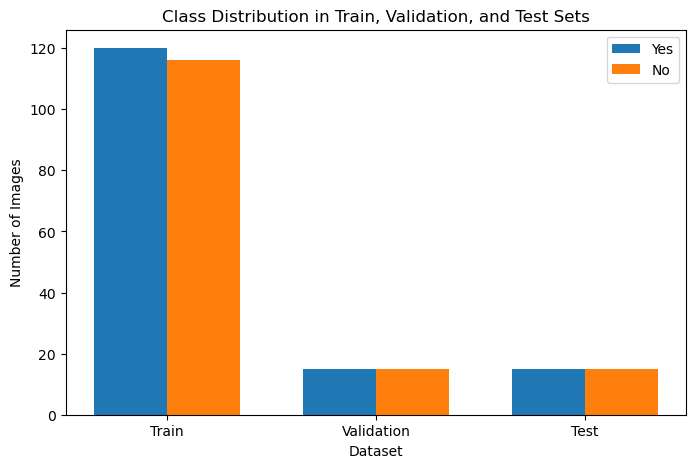

In [15]:
# Data for the bar chart to see how balanced is the data in each directory train test validation
datasets = ["Train", "Validation", "Test"]
yes_counts = [train_yes, val_yes, test_yes]
no_counts = [train_no, val_no, test_no]

# Bar width
bar_width = 0.35
x = np.arange(len(datasets))  

# Plot bars
fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(x - bar_width/2, yes_counts, bar_width, label="Yes")
ax.bar(x + bar_width/2, no_counts, bar_width, label="No")

# Labels and Title
ax.set_xlabel("Dataset")
ax.set_ylabel("Number of Images")
ax.set_title("Class Distribution in Train, Validation, and Test Sets")
ax.set_xticks(x)
ax.set_xticklabels(datasets)
ax.legend()

# Show plot
plt.show()


In [16]:
# Define CNN model
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
    MaxPooling2D(2,2),
    Dropout(0.1),  # Dropout after first Conv layer

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Dropout(0.2),  # Dropout after second Conv layer

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Dropout(0.3),  # Dropout after third Conv layer

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.4),  # Dropout before final Dense layer
    Dense(1, activation='sigmoid')  # Binary classification
])

C:\Users\yacin\anaconda3\anaconda\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [17]:
#Compile model
model.compile(optimizer=Adam(learning_rate=0.005),
              loss='binary_crossentropy',
              metrics=['accuracy'])
#Print model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# early stoping in cas of an overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,  
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 497ms/step - accuracy: 0.4377 - loss: 2.3794 - val_accuracy: 0.5000 - val_loss: 0.6913
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 455ms/step - accuracy: 0.6566 - loss: 0.6556 - val_accuracy: 0.7000 - val_loss: 0.6503
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 432ms/step - accuracy: 0.6994 - loss: 0.6567 - val_accuracy: 0.7000 - val_loss: 0.5551
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 394ms/step - accuracy: 0.7748 - loss: 0.4738 - val_accuracy: 0.7333 - val_loss: 0.5951
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 365ms/step - accuracy: 0.8027 - loss: 0.4269 - val_accuracy: 0.7333 - val_loss: 0.5203
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 408ms/step - accuracy: 0.7909 - loss: 0.4379 - val_accuracy: 0.8333 - val_loss: 0.4481
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 423ms/step - accuracy: 0.8654 - loss: 0.3982 - val_accuracy: 0.7333 - val_loss: 0.5366
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 413ms/step - accuracy: 0.8640 - loss: 0.3784 - val_accuracy: 0.8667 - val_loss:

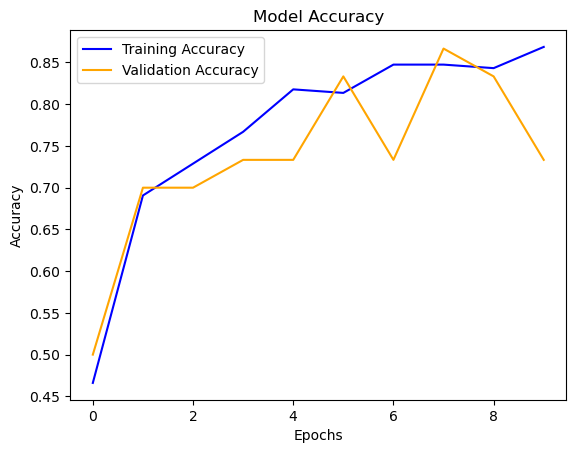

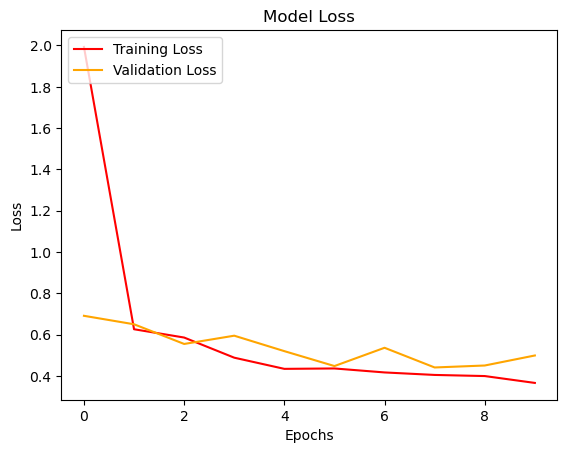

In [19]:
# Plot the training and validation accuracy 
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')  # Blue for training accuracy
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')  # Green for validation accuracy
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

# Plot the training and validation loss 
plt.plot(history.history['loss'], label='Training Loss', color='red')  # Red for training loss
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')  # Orange for validation loss
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step
Test Accuracy: 90.00%


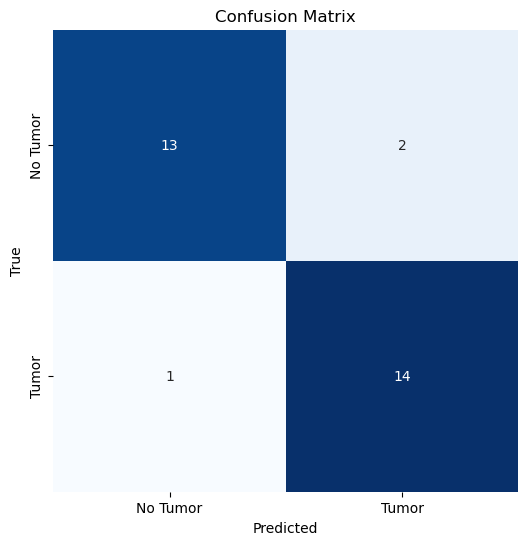

In [20]:
# Getting Predictions
y_pred = model.predict(X_test)  

# Convertting probabilities to class labels
y_pred_labels = (y_pred > 0.6).astype(int)

# Ensure y_test is correctly formatted
y_test = np.array(y_test).flatten()  # 1D shape

# If y_test is one-hot encoded, convert it to labels
if y_test.ndim > 1:
    y_test = np.argmax(y_test, axis=1)

# Calculate Accuracy
accuracy = np.mean(y_pred_labels.flatten() == y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

# Generate Confusion Matrix
cm = confusion_matrix(y_test, y_pred_labels)

# Visualize Confusion Matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False, 
            xticklabels=['No Tumor', 'Tumor'], yticklabels=['No Tumor', 'Tumor'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [21]:
# Calculate Precision, Recall, F1-score
precision = precision_score(y_test, y_pred_labels)
recall = recall_score(y_test, y_pred_labels)
f1 = f1_score(y_test, y_pred_labels)

print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')


Precision: 0.88
Recall: 0.93
F1 Score: 0.90
